# Investigation Four Streaming State Assignment

The dataset in this application is from a temperature sensor on an industrial cooling water flow. 

The data is read on a two second interval, and indexed $0,.., n$ as required by __trcrpm__.

The investigation is to determine whether __trcrpm__ state assignment signal may be useful for identifying signal anomalies in a quasi real time batch updating fashion. 

The majority of this file is taken from the __trcrpm__ tutorials.  It is included to demonstrate the 
basic functionality of the code base, as well as to highlight intuitively, the __trcrpm__ algorithm.

In [5]:
# the required python libraries imported
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from trcrpm import TRCRP_Mixture
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook
from bokeh.core.validation import silence
from bokeh.core.validation.warnings import MISSING_RENDERERS
from bokeh.layouts import column
from IPython.core.display import display, HTML

In [6]:
# indicates to jupyer how the plots are to be displayed and sized and some other
# housekeeping particular to this notebook
plt.rcParams['figure.figsize'] = [15, 10]
display(HTML("<style>div.output_scroll { height: 60em; }</style>"))
%matplotlib inline
silence(MISSING_RENDERERS, True)

{1000}

In [7]:
data = pd.read_csv("../data/anomaly0245.csv", index_col=0)

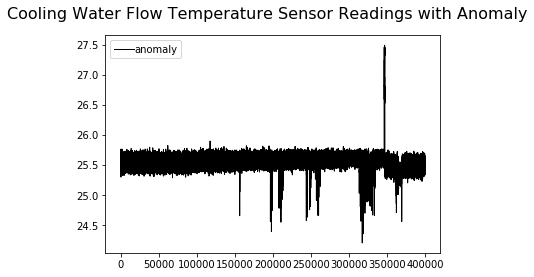

In [8]:
# Plot the data
fig, axes = plt.subplots(nrows=len(data.columns))
fig.suptitle('Cooling Water Flow Temperature Sensor Readings with Anomaly', fontsize=16)
index = list(data.columns).index(data.columns[0])
x_observed = data.index
y_observed = data.loc[:,data.columns[0]]
axes.plot(x_observed, y_observed, label=data.columns[0], color='k', linewidth=1)
axes.legend(loc='upper left', handletextpad=0)

In [ ]:
# Setup the bokeh plots and call backs
output_notebook()                
p1 = figure(title=data.columns[0], plot_height=350, plot_width=800)
p2 = figure(title="CRP States", plot_height=350, plot_width=800, x_range=p1.x_range)
p = column(p1, p2)
target = show(p, notebook_handle=True)

# Setup the placekeeping and initilizing variables
chain = 0
x, eng_val, states, num_states = [], [], [], []
i = 0
step = 100
print(i)

# Provide entropy ~ number of time series
rng = np.random.RandomState(1)
# Create TRCRP_Mixture model object, with 4 MCMC chains, and a time dependency over the previous 10 samples
model = TRCRP_Mixture(chains=4, lag=10, variables=data.columns, rng=rng)
# Incorporate the first batch of data into the model
model.incorporate(data[i:i + step])
# Run MCMC inference the latent state for #steps full Gibbs sweeps through all kernels
model.resample_all(seconds=10)
# Run empirical Bayes on variable hyperparameters for full Gibbs sweeps through all kernels
model.resample_hyperparameters(seconds=10)
# Get the model state assignments and the other data ready for graphing
s = model.get_temporal_regimes('anomaly')[chain]
num_states = step * [len(sorted(set(s)))]
states = list(s[i:i + step])
eng_val = data.iloc[i:i + step, 0].tolist()
x = list(range(i, i + step ))

for i in range(step, len(data) - step, step):
    print(i)
    # Setup the bokeh plots and render via call back
    line1 = p1.line(x = x,
                   y = eng_val,
                   color='blue',
                   name='g1',
                   line_width=1)

    line2 = p2.line(x = x,
                   y = num_states,
                   color='red',
                   name='g2',
                   line_width=1)

    line3 = p2.line(x = x,
                   y = states,
                   color='green',
                   name='g3',
                   line_width=1)
    push_notebook(handle=target)
    # Incorporate the next batch of data into the model
    model.incorporate(data[i:i + step])
    # Run MCMC inference the latent state for #steps full Gibbs sweeps through all kernels
    model.resample_all(seconds=10)
    # Run empirical Bayes on variable hyperparameters for full Gibbs sweeps through all kernels
    model.resample_hyperparameters(seconds=10)
    # Get the model state assignments and the other data ready for graphing
    s = model.get_temporal_regimes("anomaly")[chain]
    num_states = step * [len(sorted(set(s)))]
    states = list(s[i:i + step])
    eng_val = data.iloc[i:i + step, 0].tolist()
    x = list(range(i, i + step ))

Loading BokehJS ...

0
[======                        ] 22.93%

In [ ]:
probes = model.dataset.index
numsamples = 20
samples = model.simulate(probes, model.variables, numsamples)

In [ ]:
def plot_latent_state_sequence(timesteps, values, states, ax):
    assert len(timesteps) == len(states)
    unique = sorted(set(states))
    colors = matplotlib.cm.Set1(np.linspace(0, 1, len(unique)))
    y_low, y_high = ax.get_ylim()
    y_mid = np.mean([y_low, y_high])
    y_height = 0.05 * (y_high - y_low)
    for state, color in zip(unique, colors):
        xs = timesteps[states==state]
        for x in xs:
            ax.fill_between([x-1, x], [y_mid-y_height]*2, [y_mid+y_height]*2,
                alpha=0.3, color=color)

In [ ]:
def plot_predictions(simulations, variable, ax, states_from_chain=None):
    index = model.variables.index(variable)
    # Plot the observed data.
    x_observed = model.dataset.index
    y_observed = model.dataset.loc[:,variable]
    ax.plot(x_observed, y_observed, label=variable, color='k', linewidth=1)
    # Plot 25--75 percentile bands around the simulated data. 
    samples = simulations[:,:,index]
    ax.fill_between(
        probes,
        np.percentile(samples, 25, axis=0),
        np.percentile(samples, 75, axis=0),
        color='gray',
        alpha=0.5)
    #ax.set_ylim([min(y_observed)-2, max(y_observed)+2])
    #  Optionally plot latent temporal state at each timepoint,
    #  according to a given chain in the model.
    if states_from_chain is not None:
        assert 0 <= states_from_chain < model.chains
        states = model.get_temporal_regimes(variable)[states_from_chain]
        plot_latent_state_sequence(x_observed, y_observed, states, ax)
    # Add the legend.
    ax.legend(loc='upper left', handletextpad=0)

In [ ]:
fig, axes = plt.subplots(nrows=1)
plot_predictions(samples, 'anomaly', axes)
axes.set_xlim([min(probes), max(probes)])
fig.set_size_inches(20,10)

In [ ]:
chain = 0
samples_chain = samples[numsamples*chain:numsamples*(chain+1)]

In [ ]:
fig, axes = plt.subplots(nrows=1)
plot_predictions(samples_chain, 'anomaly', axes, states_from_chain=chain)
axes.set_xlim([min(probes), max(probes)])
fig.set_size_inches(20,10)

In [ ]:
probes = list(model.dataset.index) + range(max(model.dataset.index), max(model.dataset.index)+100)
numsamples = 20
samples = model.simulate(probes, model.variables, numsamples)

In [ ]:
fig, axes = plt.subplots(nrows=1)
plot_predictions(samples, 'anomaly', axes)
axes.set_xlim([min(probes), max(probes)])
fig.set_size_inches(20,10)

In [ ]:
%qtconsole